In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os

In [4]:
file_path = 'C:/Users/matil/Documents/GitHub/DataMining_G31/Data/DM2425_ABCDEats_DATASET.csv'
pd.set_option('display.max_columns', None)
df = pd.read_csv(file_path)
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
sys.path.append(os.path.abspath(os.path.join('..')))

from Functions.CleanUp import cleanUp

df= cleanUp(df)

There are repeated values in the dataset
      customer_id customer_region  customer_age  vendor_count  product_count  \
20855  742ca068fc            8550          20.0             1              2   
20907  742ca068fc            8550          20.0             1              2   

       is_chain  first_order  last_order last_promo payment_method  \
20855         0         35.0          35   No_Promo           CARD   
20907         0         35.0          35   No_Promo           CARD   

       CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
20855           0.0        0.0            0.0       0.0                 0.0   
20907           0.0        0.0            0.0       0.0                 0.0   

       CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
20855          0.0           0.0          0.0         0.0          0.0   
20907          0.0           0.0          0.0         0.0          0.0   

       CUI_Japanese  CUI_Noodle Dishes  CUI_OT

In [10]:
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,delta_day_order,tot_value_cui,order_freq,value_freq,avg_order_value
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2.0,28.88,2.500000,14.440,5.776
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2.0,19.21,1.000000,9.605,9.605
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.0,9.20,1.000000,4.600,4.600
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3.0,31.56,1.000000,10.520,10.520
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,No_Promo,DIGI,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,55.44,1.666667,18.480,11.088


In [12]:
cui_columns = [col for col in df.columns if col.startswith('CUI')]
df[cui_columns].describe()

,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
count,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000,31888.000000
mean,4.880438,9.960451,2.300633,0.801163,0.768096,1.431218,0.884359,0.950203,1.631153,3.233411,2.995379,0.711676,2.999913,3.913253,0.841697
std,11.654018,23.564351,8.479734,6.427132,3.657273,8.191755,5.259868,5.830590,7.443234,11.247990,10.180851,4.536457,9.768300,15.548507,4.433047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.660000,11.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,280.210000,896.710000,229.220000,326.100000,219.660000,739.730000,230.070000,255.810000,309.070000,468.330000,706.140000,275.110000,366.080000,454.450000,136.380000


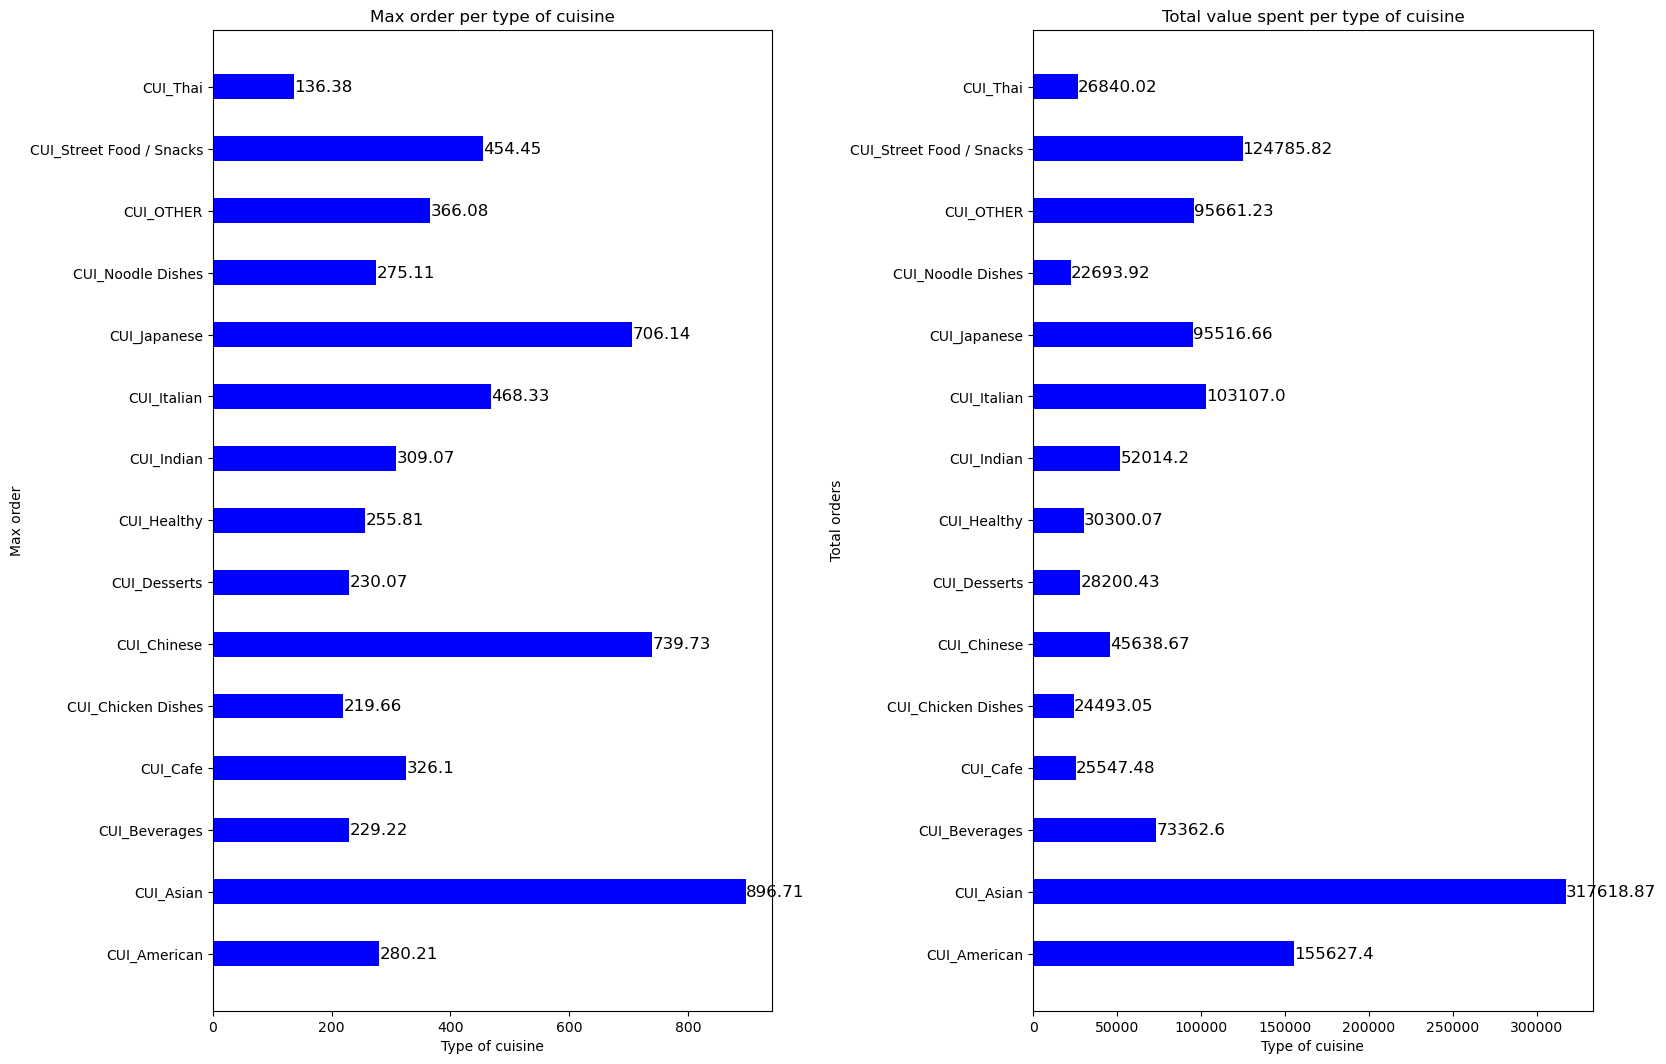

In [13]:
max_values = df[cui_columns].max()
sum_values = df[cui_columns].sum().round(2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 11))

axes[0].barh(max_values.index, max_values.values, color='blue', height=0.4)
axes[0].set_title('Max order per type of cuisine')
axes[0].set_xlabel('Type of cuisine')
axes[0].set_ylabel('Max order')
for i in range(len(max_values)):
    axes[0].text(max_values.values[i] + 1, i, str(max_values.values[i]), va='center', fontsize=12)

axes[1].barh(sum_values.index, sum_values.values, color='blue', height=0.4)
axes[1].set_title('Total value spent per type of cuisine')
axes[1].set_xlabel('Type of cuisine')
axes[1].set_ylabel('Total orders')
for i in range(len(sum_values)):
    axes[1].text(sum_values.values[i] + 1, i, str(sum_values.values[i]),va='center', fontsize=12)

plt.tight_layout(pad=2.0)
plt.show()

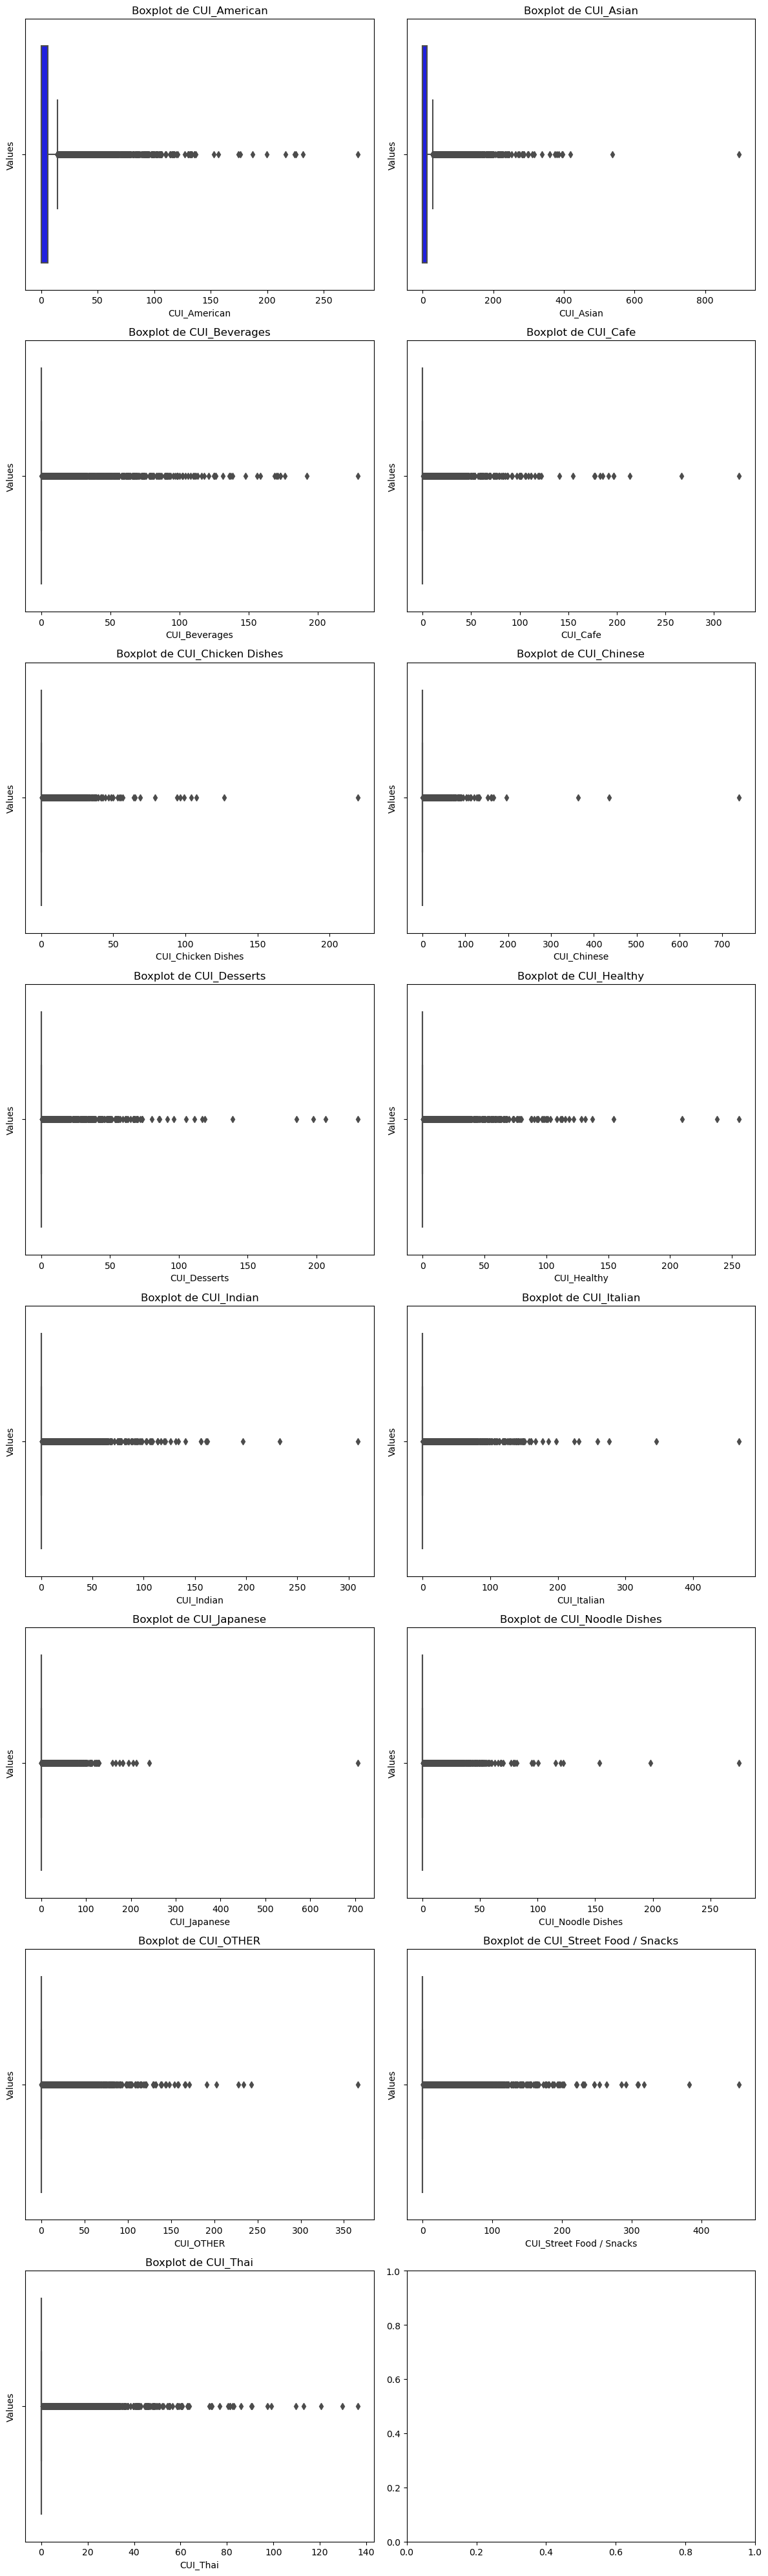

In [14]:
fig, axes = plt.subplots(8, 2, figsize=(12, 40))

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    axes[i].set_ylim(0, 150)
    sns.boxplot(x=df[column], color='blue', ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_ylabel('Values')

plt.tight_layout()  
plt.show()

In [40]:
#The boxplots are not readable like this because of the null values in each column. The 75% quartil is 0 in almost every cuisine
#So we will repeat it but without the nulls

In [15]:
df_sem0 = df[df[cui_columns] != 0]
df_sem0[cui_columns].describe() #check if the nulls are out

,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
count,10795.000000,11905.000000,5435.000000,1366.000000,3248.000000,3522.000000,2016.000000,2169.000000,3448.000000,6448.000000,6301.000000,2226.000000,7041.000000,4249.000000,2378.000000
mean,14.416619,26.679451,13.498178,18.702401,7.540964,12.958169,13.988309,13.969604,15.085325,15.990540,15.158968,10.194933,13.586313,29.368280,11.286804
std,16.239699,32.269526,16.455192,25.098451,8.959083,21.408096,15.950535,17.833984,17.592123,20.536117,18.444484,14.078502,16.980684,32.664366,12.070007
min,0.410000,0.440000,0.320000,0.660000,0.340000,0.440000,0.410000,0.430000,0.460000,0.340000,0.430000,0.370000,0.360000,0.440000,0.500000
25%,5.455000,8.180000,4.810000,6.692500,2.800000,4.292500,5.677500,5.260000,5.585000,4.980000,5.900000,3.082500,4.720000,8.770000,4.802500
50%,9.340000,17.980000,7.710000,11.360000,5.280000,7.460000,11.295000,8.560000,10.180000,10.260000,11.160000,6.045000,8.670000,18.950000,7.675000
75%,18.220000,31.320000,17.590000,20.360000,9.325000,15.562500,18.302500,16.880000,17.722500,19.280000,18.460000,11.797500,16.050000,37.140000,13.492500
max,280.210000,896.710000,229.220000,326.100000,219.660000,739.730000,230.070000,255.810000,309.070000,468.330000,706.140000,275.110000,366.080000,454.450000,136.380000


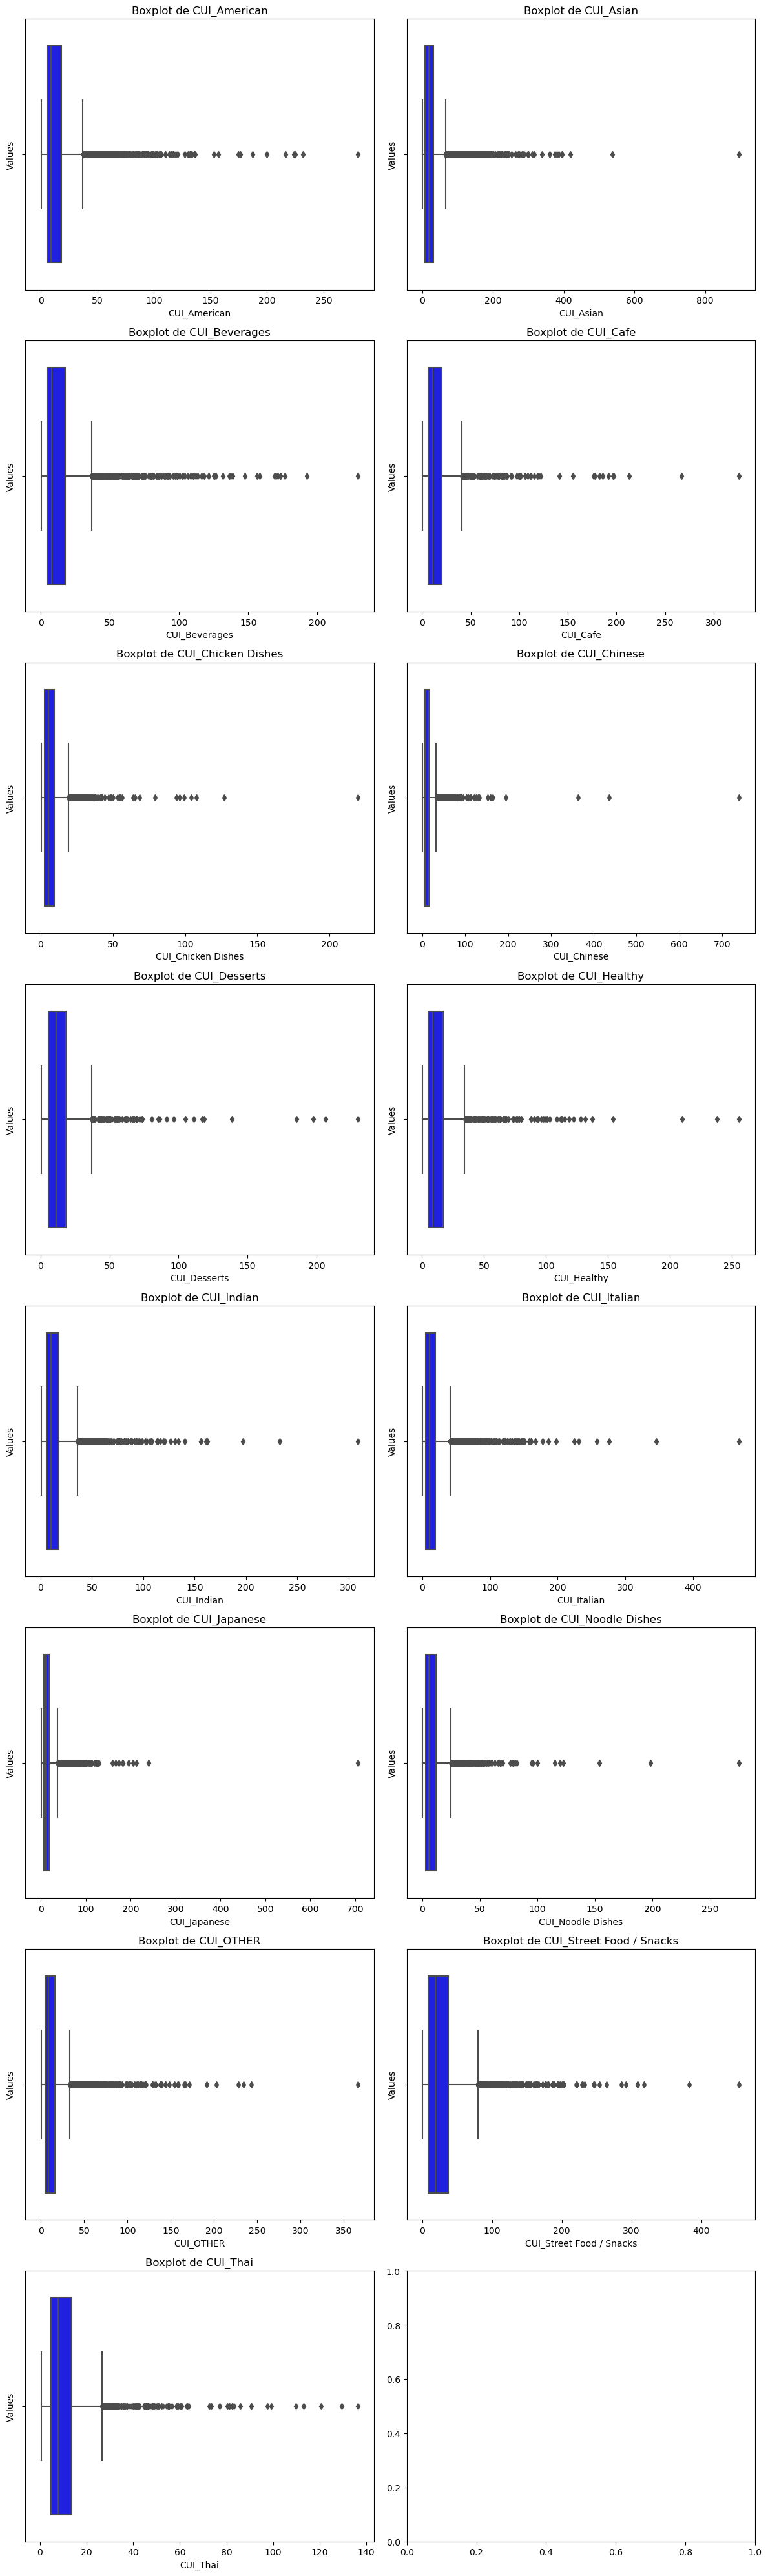

In [16]:
fig, axes = plt.subplots(8, 2, figsize=(12, 40), tight_layout=True)

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    #axes[i].set_ylim(0, 150)
    sns.boxplot(x=df_sem0[column], color='blue', ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_ylabel('Values')

plt.tight_layout()  
plt.show()

In [43]:
#We noticed that in every cuisine there is at least one big outlier and we want to compare it with the region to see if there is a correlation. Check if all the outliers come from the same region

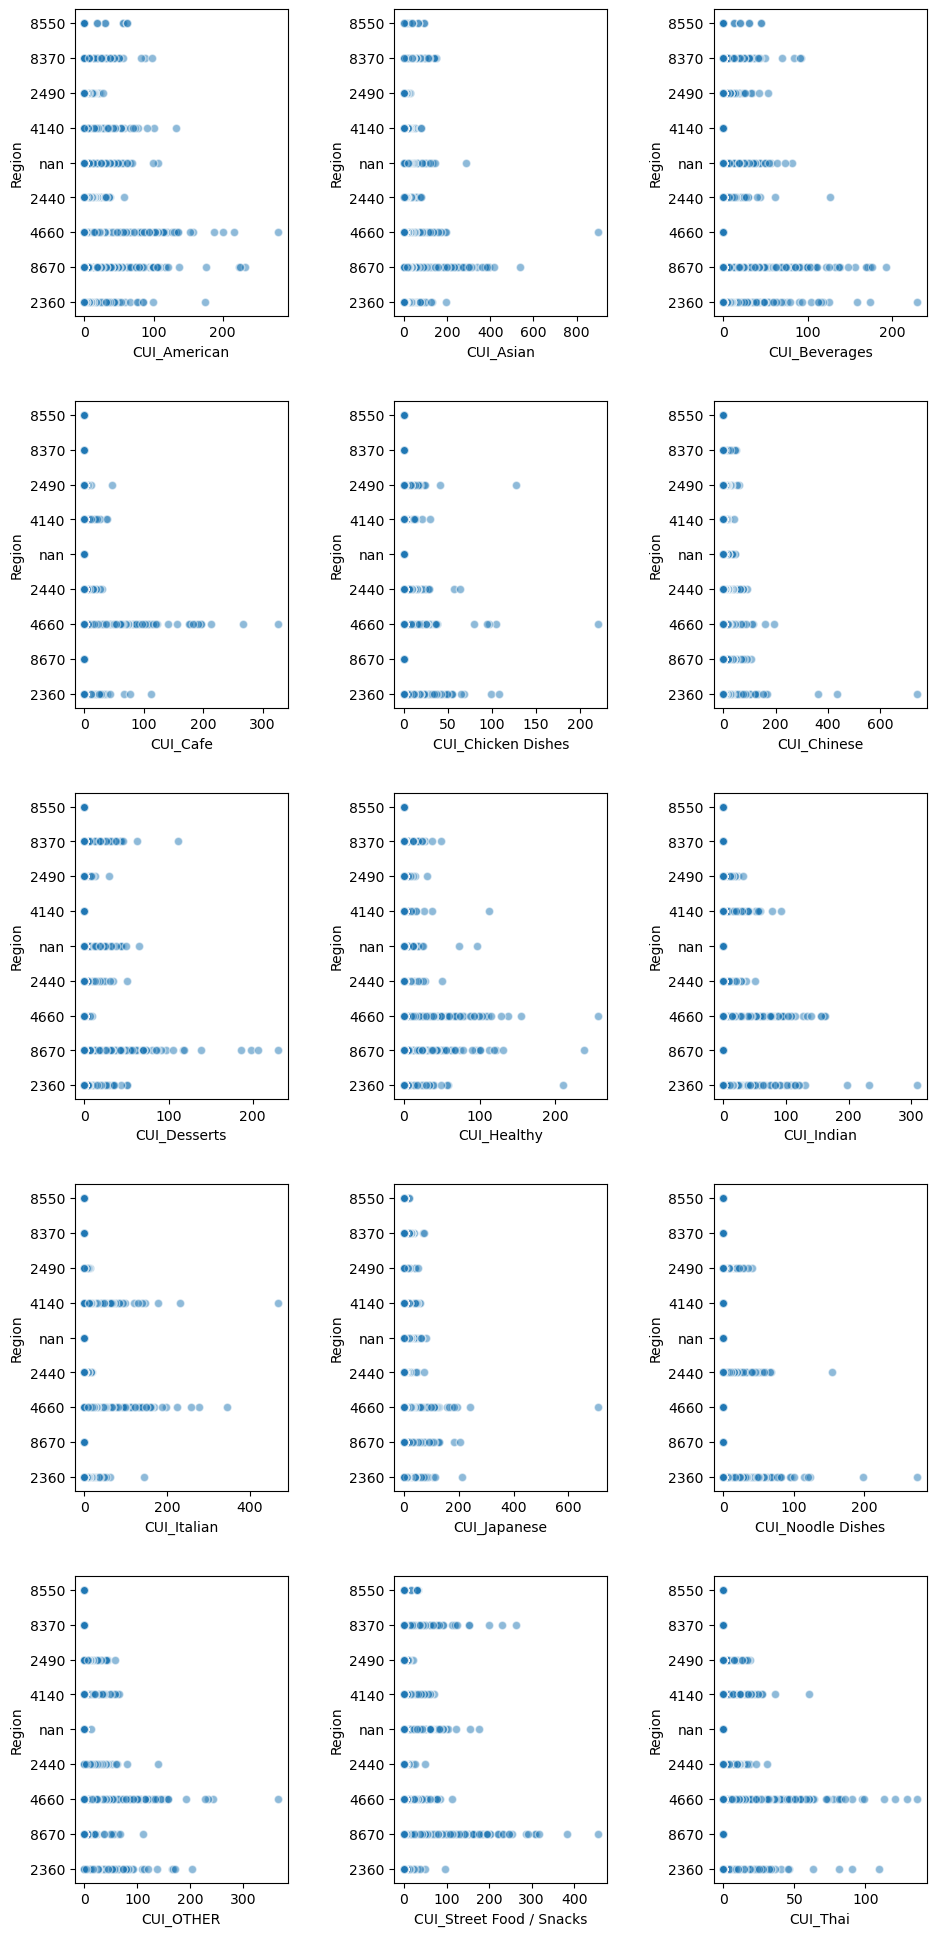

In [17]:
fig, axes = plt.subplots(5, 3, figsize=(10,20))

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    axes[i].scatter(x=df[column], y=df['customer_region'].astype(str), edgecolors="white", alpha=0.5)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Region')

plt.tight_layout(pad=3.0) 
plt.show()

In [45]:
#As we expected the outliers are in the last 3 regions. So that regions tend to spend more.
#we will do the same comparison with age

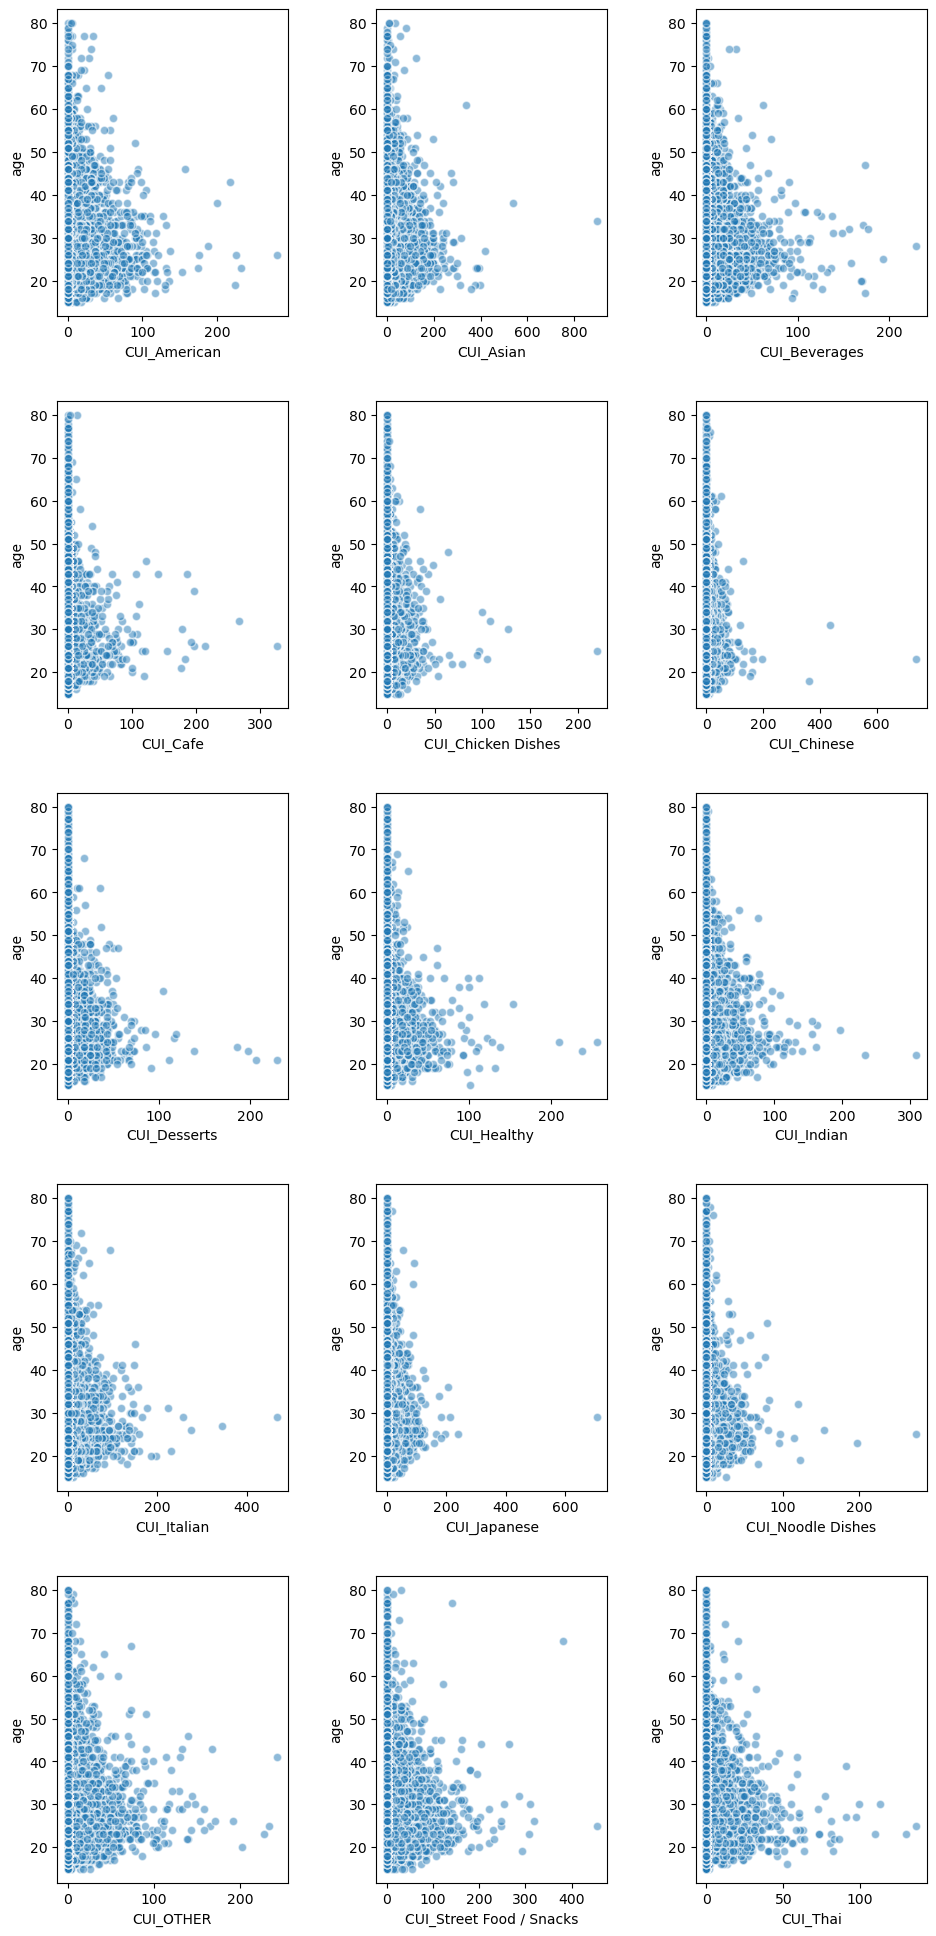

In [18]:
fig, axes = plt.subplots(5, 3, figsize=(10,20))

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    axes[i].scatter(x=df[column], y=df['customer_age'], edgecolors="white", alpha=0.5)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('age')

plt.tight_layout(pad=3.0) 
plt.show()

In [47]:
#we noticed that the bigger orders are placed by people between the 20 years old and 30 years old. 
#However we've seen before that we have a lot more data of younger people (the mean of customer_age is 27.507545).

In [19]:
regions = df["customer_region"].unique()

for region in regions: 
    unique_region = df[df["customer_region"] == region]
    total = unique_region[cui_columns].sum(axis = 0)
    
    radar = pd.DataFrame(dict(r=total, theta=cui_columns))
    fig = px.line_polar(radar, r='r', theta='theta', line_close=True)
    fig.update_layout(title=f'Region {region} Radar Chart')
    fig.show()

AttributeError: 'DataFrame' object has no attribute 'append'

Payment Method

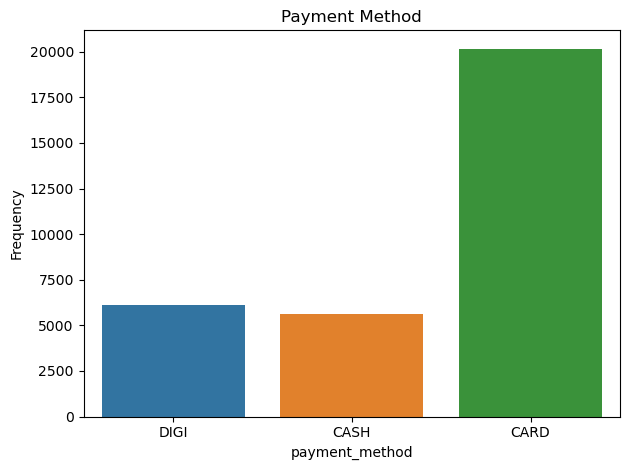

In [20]:
sns.countplot(x=df['payment_method'])
plt.title('Payment Method')
plt.ylabel('Frequency')

axes = axes.flatten()
plt.tight_layout()  
plt.show()

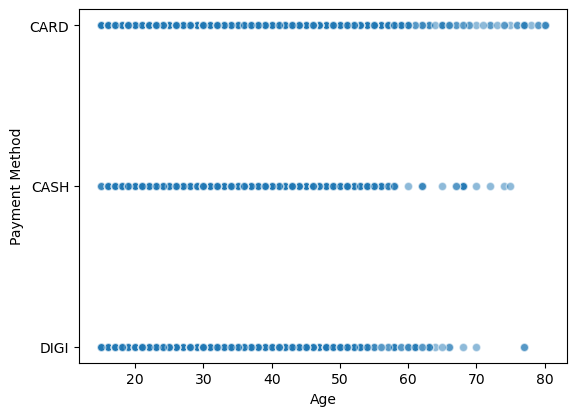

In [21]:
plt.scatter(x=df['customer_age'], y=df['payment_method'], edgecolors="white", alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Payment Method')

plt.tight_layout(pad=3.0) 
plt.show()

In [22]:
df['is_chain'].describe()

count    31888.000000
mean         2.818866
std          3.977529
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         83.000000
Name: is_chain, dtype: float64

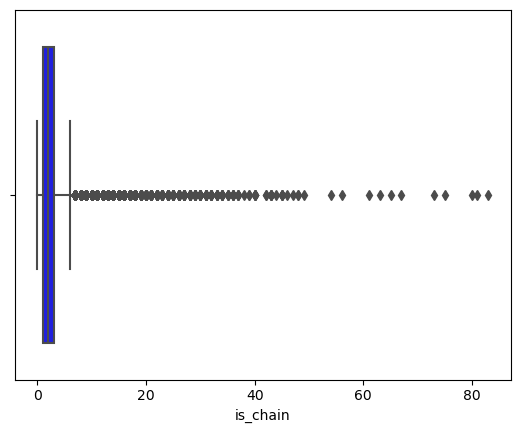

In [23]:
sns.boxplot(x=df['is_chain'], color='blue')
plt.show()